This demonstration will show how to reproject the NEMO velocities for plotting.

NEMO velocities are usually calculated and saved in along grid i and j directions. This causes an issue when plotting velocities as vectors on a map where it is assumed that i and j velocities point eastwards and northwards.

There are additonal isses when plotting quivers over the poles that we will cover.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import coast


### Usage of coast._utils.plot_util.velocity_grid_to_geo()

Plotting velocities on a polar stereographic projection.

In [3]:
root = "../../../../"
# Paths to a single or multiple data files.
dn_files = root + "example_files/"
fn_nemo_dat_t = dn_files + "HadGEM3-GC31-HH_hist_thetao.nc"
#fn_nemo_dat_t = dn_files + "thetao_Omon_HadGEM3-GC31-HH_hist-1950_r1i1p1f1_gn_195001-195001.nc"
fn_nemo_dat_u = dn_files + "HadGEM3-GC31-HH_hist_uo.nc"
fn_nemo_dat_v = dn_files + "HadGEM3-GC31-HH_hist_vo.nc"
fn_nemo_config_t = root + "config/gc31_nemo_grid_t.json"
fn_nemo_config_u = root + "config/gc31_nemo_grid_u.json"
fn_nemo_config_v = root + "config/gc31_nemo_grid_v.json"
# Set path for domain file if required.
#fn_nemo_dom = dn_files + "eORCA12_v2.4_domain.nc"
fn_nemo_dom = dn_files + "gc31_domain.nc"
#fn_nemo_dom = dn_files + "mesh_mask_eORCA12_v2.4.nc"
# Define output filepath (optional: None or str)
fn_out = './quiver_plot.png'

# Read in multiyear data (This example uses NEMO data from a single file.)
nemo_data_t = coast.Gridded(fn_data=fn_nemo_dat_t,
                          fn_domain=fn_nemo_dom,
                          config=fn_nemo_config_t,
                          ).dataset
nemo_data_u = coast.Gridded(fn_data=fn_nemo_dat_u,
                          fn_domain=fn_nemo_dom,
                          config=fn_nemo_config_u,
                          ).dataset
nemo_data_v = coast.Gridded(fn_data=fn_nemo_dat_v,
                          fn_domain=fn_nemo_dom,
                          config=fn_nemo_config_v,
                          ).dataset

Select surface u and v as an example:

In [7]:
#print(nemo_data_t)
# Coarsen the data to make it run faster
nemo_data_uc = nemo_data_u.coarsen(y_dim=4, x_dim=5).mean()
nemo_data_vc = nemo_data_v.coarsen(y_dim=4, x_dim=5).mean()
nemo_data_tc = nemo_data_t.coarsen(y_dim=4, x_dim=5).mean()
print('done1')

# Select specific data variables.
data_u = nemo_data_uc[["u_velocity"]]
data_v = nemo_data_vc[["v_velocity"]]

# Select one time step and surface currents
data_u = data_u.isel(t_dim=0, z_dim=0)
data_v = data_v.isel(t_dim=0, z_dim=0)
print('done2')

# Calculate speed
speed = ((data_u.to_array().values[0, :, :] ** 2 + data_v.to_array().values[0, :, :] ** 2) ** 0.5)
print('done3')

print(nemo_data_tc.longitude.shape)
# Calculate adjustment
u_new, v_new = coast._utils.plot_util.velocity_grid_to_geo(
        nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, 
        data_u.to_array().values[0, :, :], data_v.to_array().values[0, :, :], polar_stereo=False)
print('done4')


done1
<xarray.Dataset>
Dimensions:             (z_dim: 75, bnds: 2, t_dim: 1, y_dim: 151, x_dim: 864,
                         vertices: 4)
Coordinates:
    i                   (x_dim) float64 2.0 7.0 12.0 ... 4.312e+03 4.317e+03
    j                   (y_dim) float64 3.002e+03 3.006e+03 ... 3.602e+03
    latitude            (y_dim, x_dim) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    depth_0             (z_dim, y_dim, x_dim) float64 0.0 0.0 0.0 ... 0.0 0.0
    longitude           (y_dim, x_dim) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    time                (t_dim) object 1950-01-16 00:00:00
Dimensions without coordinates: z_dim, bnds, t_dim, y_dim, x_dim, vertices
Data variables:
    lev_bnds            (z_dim, bnds) float64 dask.array<chunksize=(75, 2), meta=np.ndarray>
    temperature         (t_dim, z_dim, y_dim, x_dim) float32 dask.array<chunksize=(1, 75, 151, 864), meta=np.ndarray>
    time_bnds           (t_dim, bnds) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    vert

In [8]:
# Apply the CartoPy steroegraphic polar correction
# NOTE: This coul have been applied automatically with the, polar_stereo=True in 
# coast._utils.plot_util.velocity_grid_to_geo()

u_pol, v_pol = coast._utils.plot_util.velocity_polar(u_new, v_new, nemo_data_tc.latitude.values)

In [9]:
# Set things up for plotting North Pole stereographic projection

def set_circle(ax):
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

# Data projection
data_crs = ccrs.PlateCarree()
# Plot projection
mrc = ccrs.NorthPolarStereo(central_longitude=0.0)

Below shows the u and v velocities when plotted with and without adjustment.

The plot shows three cases: 1:no correction, 2:the NEMO grid correction, and 3:the NEMO grid correction with polar sterographic plot correction. We also plot the final corrected u and v velocities as streamlines.
- In case 1, the lowere latutude velocities aren't too bad but become irregular further north as the grid lines deviate form lat and lon.
- In case 2, the irrigulary still persits even with the grid correction. This is the result of a CartPy bug which also worsens at high latitudes.
- In case 3, both corrections have been applied and the velocites quivers now align with the route of strong current speed as would be expected.

C:\Users\benbar\AppData\Local\Temp\ipykernel_20044\1333368922.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(w_pad=subplot_padding, h_pad=subplot_padding)


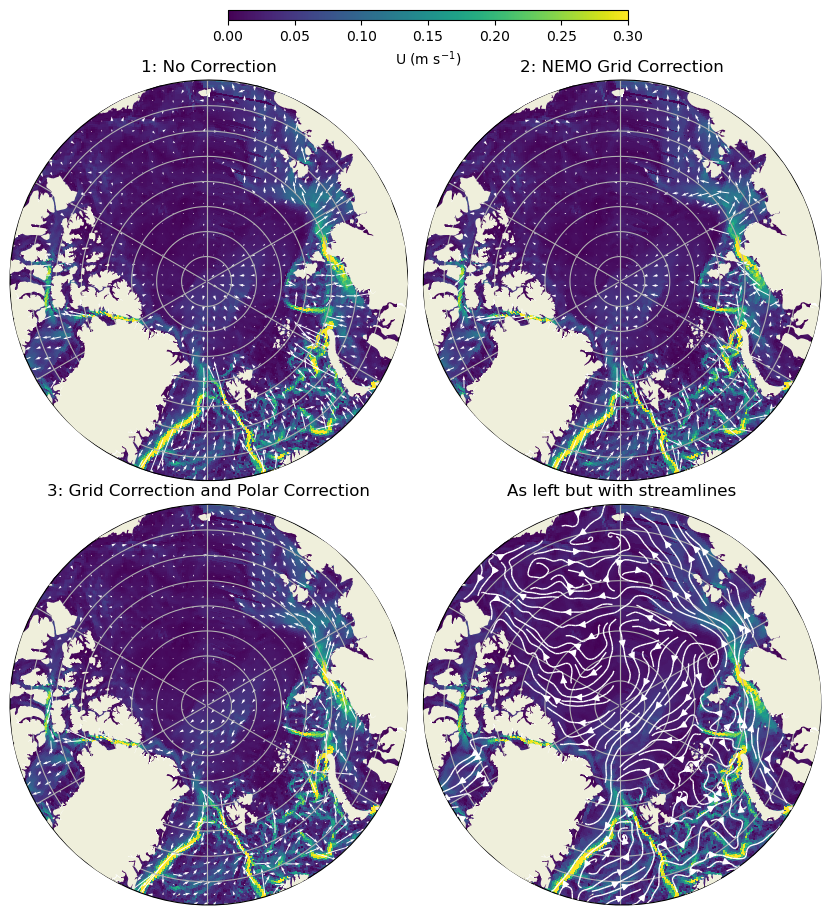

In [23]:
# Subplot axes settings
n_r = 2  # Number of subplot rows
n_c = 2  # Number of subplot columns
figsize = (10, 10)  # Figure size
subplot_padding = 0.5  # Amount of vertical and horizontal padding between plots
fig_pad = (0.075, 0.075, 0.1, 0.1)  # Figure padding (left, top, right, bottom)

# Labels and Titles
fig_title = "Velocity Plot"  # Whole figure title

# Create plot and flatten axis array
fig, ax = plt.subplots(n_r, n_c, subplot_kw={"projection": mrc}, sharey=True, sharex=True, figsize=figsize)
cax = fig.add_axes([0.3, 0.96, 0.4, 0.01])

if n_r * n_c > 1:
    ax = ax.flatten()
    for rr in range(n_r * n_c):
        ax[rr].add_feature(cfeature.LAND, zorder=100)
        ax[rr].gridlines()
        ax[rr].set_extent([-180, 180, 70, 90], crs=data_crs)
        set_circle(ax[rr])


cs = ax[0].pcolormesh(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, speed, transform=data_crs, vmin=0, vmax=0.3)
ax[0].quiver(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, 
    data_u.to_array().values[0, :, :], data_v.to_array().values[0, :, :], 
    color='w', transform=data_crs, angles='xy', regrid_shape=40)

ax[1].pcolormesh(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, speed, transform=data_crs, vmin=0, vmax=0.3)
ax[1].quiver(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, 
    u_new, v_new, 
    color='w', transform=data_crs, angles='xy', regrid_shape=40)

ax[2].pcolormesh(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, speed, transform=data_crs, vmin=0, vmax=0.3)
ax[2].quiver(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, 
    u_pol, v_pol, 
    color='w', transform=data_crs, angles='xy', regrid_shape=40)

ax[3].pcolormesh(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, speed, transform=data_crs, vmin=0, vmax=0.3)
ax[3].streamplot(nemo_data_tc.longitude.values, nemo_data_tc.latitude.values, 
    u_pol, v_pol, transform=data_crs, linewidth=1, density=2, color='w', zorder=101)

ax[0].set_title('1: No Correction')
ax[1].set_title('2: NEMO Grid Correction')
ax[2].set_title('3: Grid Correction and Polar Correction')
ax[3].set_title('As left but with streamlines')

fig.colorbar(cs, cax=cax, orientation='horizontal')
cax.set_xlabel('U (m s$^{-1}$)')

fig.tight_layout(w_pad=subplot_padding, h_pad=subplot_padding)
fig.subplots_adjust(left=(fig_pad[0]), bottom=(fig_pad[1]), right=(1 - fig_pad[2]), top=(1 - fig_pad[3]))

plt.show()